In [1]:
import pystan as stan
from scipy.special import logit, expit
from numpy.random import normal, choice, binomial, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#ckmr_model = stan.CmdStanModel(stan_file='~/src/ckmr/src/sib.stan')
ckmr_model_full = stan.StanModel(file='/home/alex/src/ckmr/src/sib_full.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d4f319fda87ef98c4f655f3b1303d38 NOW.


In [3]:
df = pd.read_excel('PIRU_mykiss_parentage.xlsx')
df = df[df['Count'] > 0]
df = df[['Count']]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [3]:
def preprocess_data(df):
    df = df[['OffspringID', 'MotherID', 'FatherID']]
    df = df.groupby(['MotherID', 'FatherID'], as_index=False).count()
    df = df.rename(columns={'OffspringID': 'Count'})
    df = df[df['Count'] > 0]
    return df
    
def sub_sample(df, p=0.1):
    tot = df['Count'].sum()
    new_count = binomial(df['Count'], p)
    df1 = df[set(df.columns).difference({'Count'})]
    df1['Count'] = new_count
    df1 = df1[df1['Count'] > 0]
    return df1
    

def make_stan_data(df, method='normal', osr=[0.0, 0.01], prom=[-2.5, 0.11]):
    if method == 'normal':
        method = 1
    elif method == 'beta':
        method = 2
    else:
        raise ValueError(f'Invalid method: {method}')
    data = {
        'method': method,
        'osr_mu': osr[0],
        'osr_sigma': osr[1],
        'G': len(df['Count']),
        'M': df['FatherID'].nunique(),
        'F': df['MotherID'].nunique(),
        'N': df['Count'].sum(),
        'grp_size': df['Count'].values
    }
    return data

def plot_results(dfs, field='F0', ci=0.99, title='', label='', ax=None):
    dfs = summarize_samples(dfs, ci=ci, field=field)
    ns = [d[0] for d in dfs]
    summaries = [d[1] for d in dfs]
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 9))
    y0 = [s[field].loc['mean'] for s in summaries]
    y1 = [s[field].iloc[4] for s in summaries]
    y2 = [s[field].iloc[6] for s in summaries]
    ax.plot(ns, y0, 'o-', label=f'{label} mean')
    ax.fill_between(ns, y1, y2, alpha=0.5, label=f'{label} {(100*ci):.1f}% CI')
    ax.set_xlabel('sample size')
    ax.set_ylabel(f'{field} estimate')
    ax.set_title(title)
    return ax
    
def sample_data(dfs, method='normal', **kwargs):
    fits = [(d['Count'].sum(), ckmr_model_full.sampling(data=make_stan_data(d, method=method), **kwargs)) for d in dfs]
    fits.sort(key=(lambda x: x[0]))
    return fits

def summarize_samples(fits, ci=0.99, field='F0'):
    lower = 0.5 * (1.0 - ci)
    upper = 1.0 - lower
    quants = (lower, upper)
    res = [(n, d.to_dataframe(pars=[field]).describe(percentiles=quants)) for (n, d) in fits]
    return res
    
def make_synth_data(M0, F0, G0, N):
    N0 = M0 + F0
    ms = choice(M0, size=G0, replace=True)
    fs = choice(F0, size=G0, replace=True)
    xs = choice(G0, size=N)
    df = pd.DataFrame(data={'OffspringID': np.arange(N), 'FatherID': ms[xs], 'MotherID': fs[xs]})
    return df

In [5]:
dfs = (sub_sample(df, p=p) for p in np.arange(0.05, 1.0, 0.05))
fits = sample_data(dfs, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

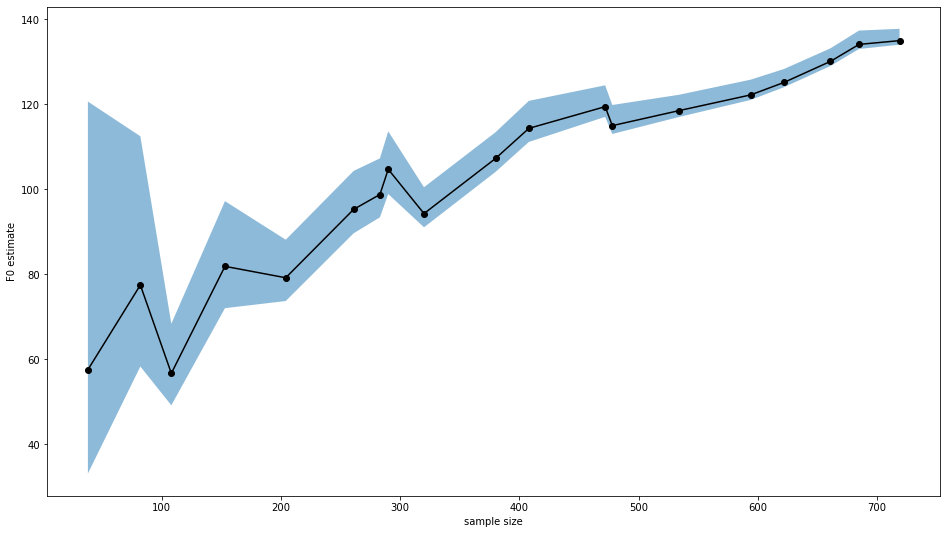

In [6]:
plot_results(fits, field='F0')

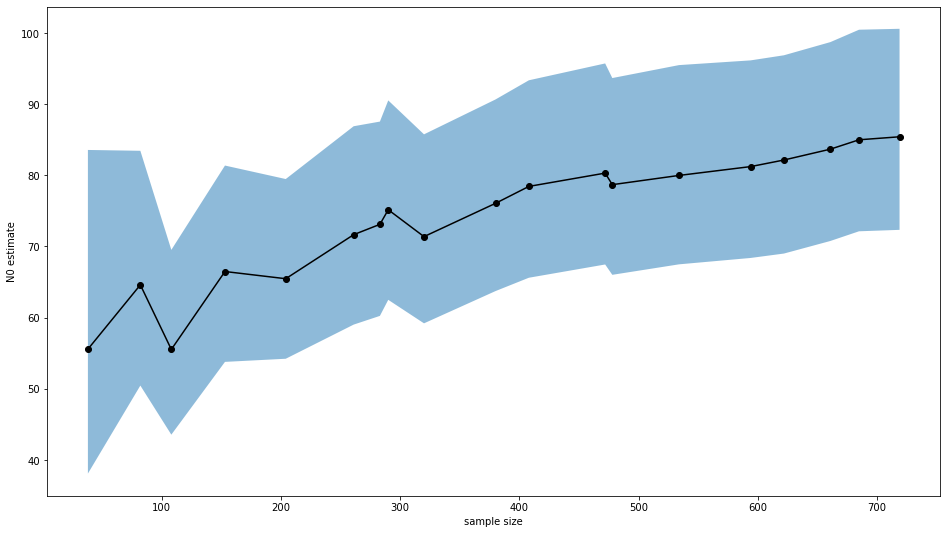

In [7]:
plot_results(fits, field='N0')

In [8]:
dfs1 = (make_synth_data(137, N) for N in range(100, 1000, 100))
fits1 = sample_data(dfs1, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

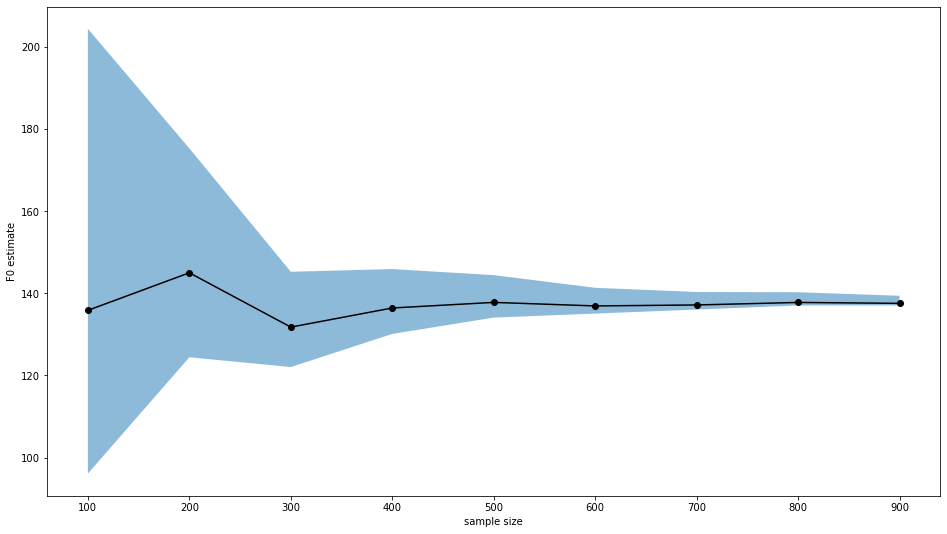

In [9]:
plot_results(fits1, field='F0')

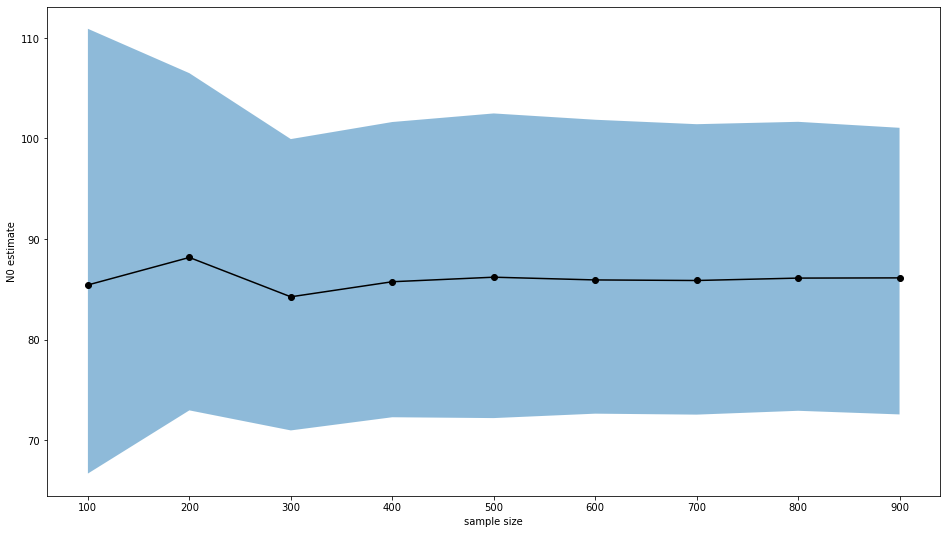

In [10]:
plot_results(fits1, field='N0')

In [4]:
dfs2 = (make_synth_data(1234, N) for N in range(200, 2200, 200))
fits2 = sample_data(dfs2, chains=4, show_progress=False, iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 

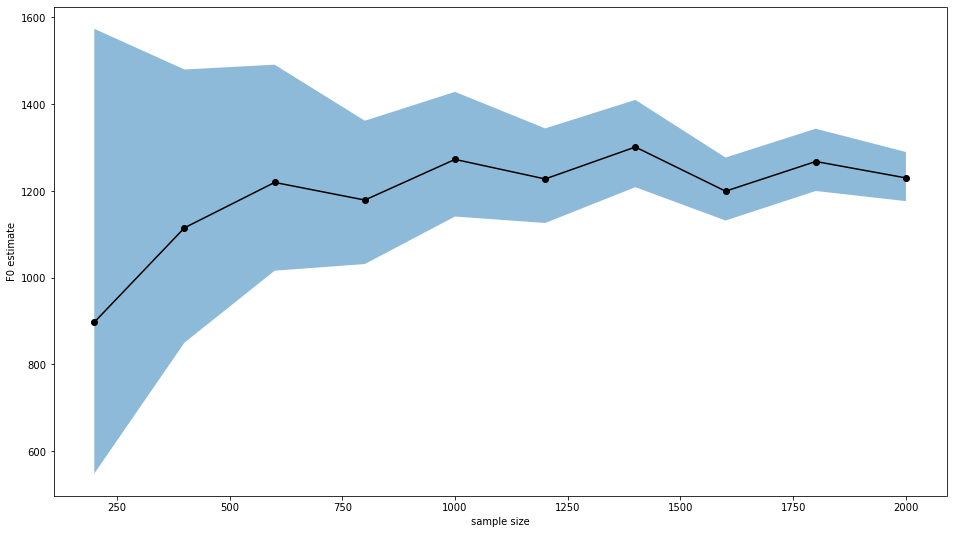

In [5]:
plot_results(fits2, field='F0')

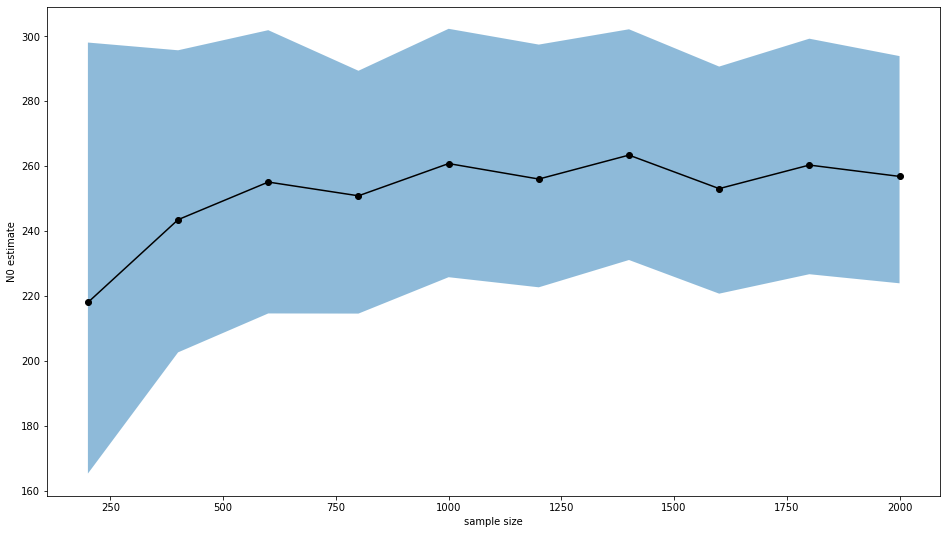

In [6]:
plot_results(fits2, field='N0')

In [23]:
df3 = preprocess_data(pd.read_csv('/home/alex/src/ckmr/Stan_mykiss_2021_Run1.BestConfig'))

In [24]:
df3

,MotherID,FatherID,Count
0,1,1,1
1,2,2,1
2,3,3,2
3,4,4,1
4,5,5,1
...,...,...,...
125,126,126,2
126,127,127,1
127,128,128,1
128,129,129,1


In [25]:
dfs3 = [sub_sample(df3, p=p) for p in np.linspace(0.2, 1.0, 18)]
norm3 = sample_data(dfs3, method='normal', chains=4, iter=2000)
beta3 = sample_data(dfs3, method='beta', chains=4, iter=2000)

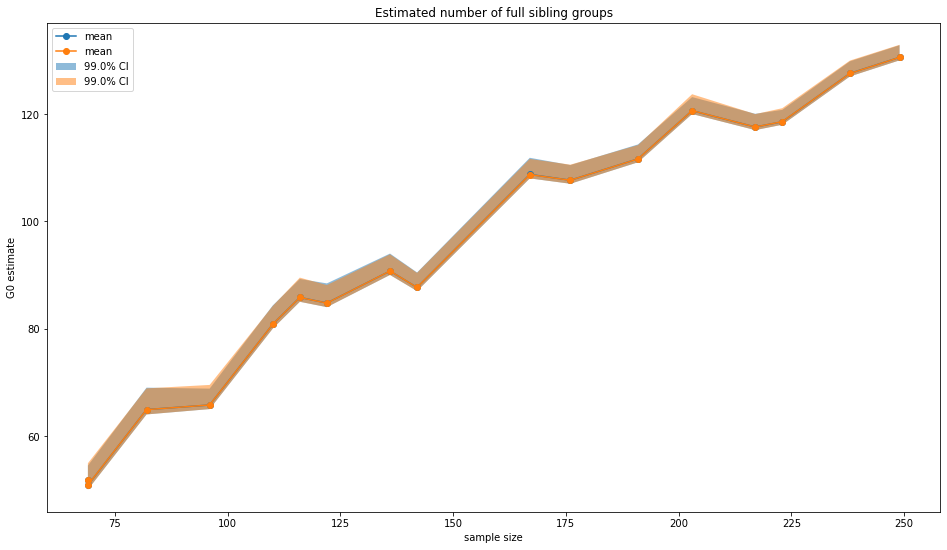

In [26]:
ax = plot_results(norm3[1:], field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta3[1:], field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

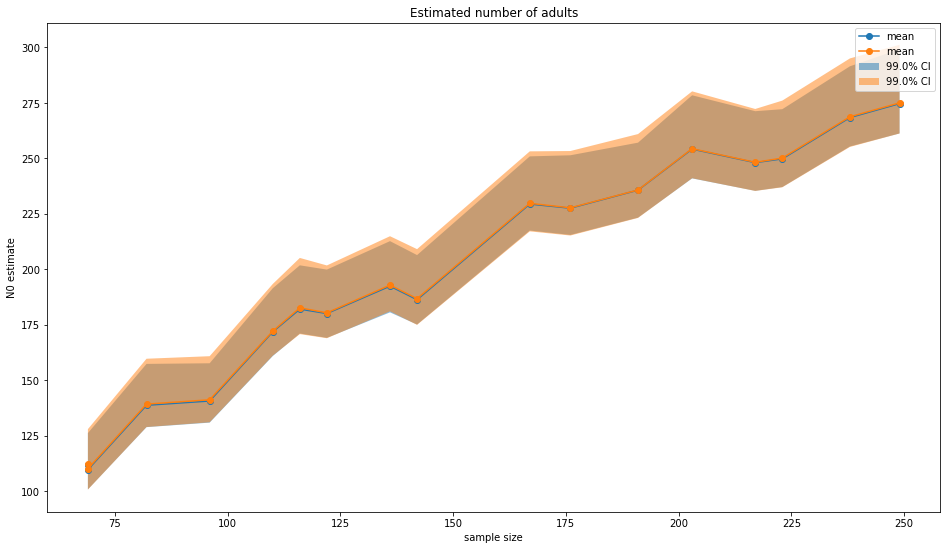

In [27]:
ax = plot_results(norm3[1:], field='N0', title='Estimated number of adults')
ax = plot_results(beta3[1:], field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [28]:
norm3[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,137.202380,130.560774,137.467000,274.669380,0.499930,0.914786,0.527821,2.677250,6.306500,0.0,1219.142898
std,1.118174,288.711081,0.0,5.767561,0.550808,5.951320,7.919761,0.002453,0.126707,0.032978,0.486458,1.700818,0.0,2.112800
min,0.000000,0.000000,0.0,130.001747,130.000506,130.001029,260.413160,0.492762,0.001727,0.495509,1.000000,1.000000,0.0,1215.138579
0.5%,0.000000,4.995000,0.0,130.047031,130.003748,130.055869,261.234608,0.493941,0.227007,0.495509,1.000000,3.000000,0.0,1215.507097
50%,1.500000,499.500000,0.0,135.797348,130.392336,136.128760,273.488833,0.499901,0.959459,0.516394,3.000000,7.000000,0.0,1218.837192
99.5%,3.000000,994.005000,0.0,157.695548,132.816914,157.596476,299.216525,0.506217,1.000000,0.582989,3.000000,7.000000,0.0,1226.731055
max,3.000000,999.000000,0.0,172.907480,134.915778,174.435185,312.949435,0.508230,1.000000,0.582989,4.000000,31.000000,0.0,1229.594648


In [29]:
beta3[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,137.389292,130.555273,137.611834,275.001127,0.499980,0.935227,0.477583,2.756750,6.562000,0.0,1221.053654
std,1.118174,288.711081,0.0,5.957467,0.555947,6.131964,8.164984,0.002508,0.100207,0.032682,0.447358,1.777342,0.0,2.154982
min,0.000000,0.000000,0.0,130.003254,130.000319,130.005149,260.179878,0.491368,0.001122,0.434250,1.000000,1.000000,0.0,1217.204029
0.5%,0.000000,4.995000,0.0,130.041210,130.004512,130.079625,261.208107,0.493389,0.351714,0.434250,1.000000,3.000000,0.0,1217.405574
50%,1.500000,499.500000,0.0,136.078208,130.383264,136.132684,273.772759,0.499959,0.968375,0.475144,3.000000,7.000000,0.0,1220.701020
99.5%,3.000000,994.005000,0.0,158.753700,132.901249,159.748661,301.189610,0.506277,1.000000,0.525794,3.000000,15.000000,0.0,1228.442525
max,3.000000,999.000000,0.0,173.922714,135.391049,166.756391,315.672965,0.510307,1.000000,0.525794,4.000000,31.000000,0.0,1232.270114


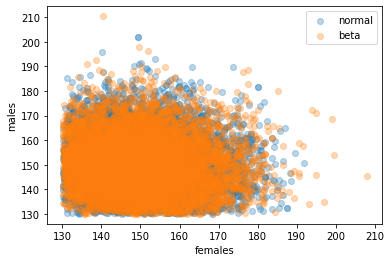

In [28]:
plt.scatter(norm3[-1][1].draws_pd(['F0'])['F0'], norm3[-1][1].draws_pd(['M0'])['M0'], alpha=0.3, label='normal')
plt.scatter(beta3[-1][1].draws_pd(['F0'])['F0'], beta3[-1][1].draws_pd(['M0'])['M0'], alpha=0.3, label='beta')
plt.xlabel('females')
plt.ylabel('males')
plt.legend()

In [32]:
beta3[-1][1].diagnose()

INFO:cmdstanpy:Processing csv files: /run/user/1000/tmpjiguiiwb/sib_full-202109232035-1-dfi1bmw5.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-2-vdx2wix1.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-3-z339lglk.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-4-5l9swl0l.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /run/user/1000/tmpjiguiiwb/sib_full-202109232035-1-dfi1bmw5.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-2-vdx2wix1.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-3-z339lglk.csv, /run/user/1000/tmpjiguiiwb/sib_full-202109232035-4-5l9swl0l.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [16]:
df4 = pd.read_csv('/home/alex/src/ckmr/Piru_mykiss-Run1.BestConfig.txt')
df4 = df4.groupby(['ClusterID', 'MotherID', 'FatherID'], as_index=False).count()
df4 = df4.rename(columns={'OffspringID': 'Count'})
df4 = df4[df4['Count'] > 0]

In [18]:
dfs4 = [sub_sample(df4, p=p) for p in np.linspace(0.1, 1.0, 19)]
norm4 = sample_data(dfs4, method='normal', chains=4, iter=2000)
beta4 = sample_data(dfs4, method='beta', chains=4, iter=2000)

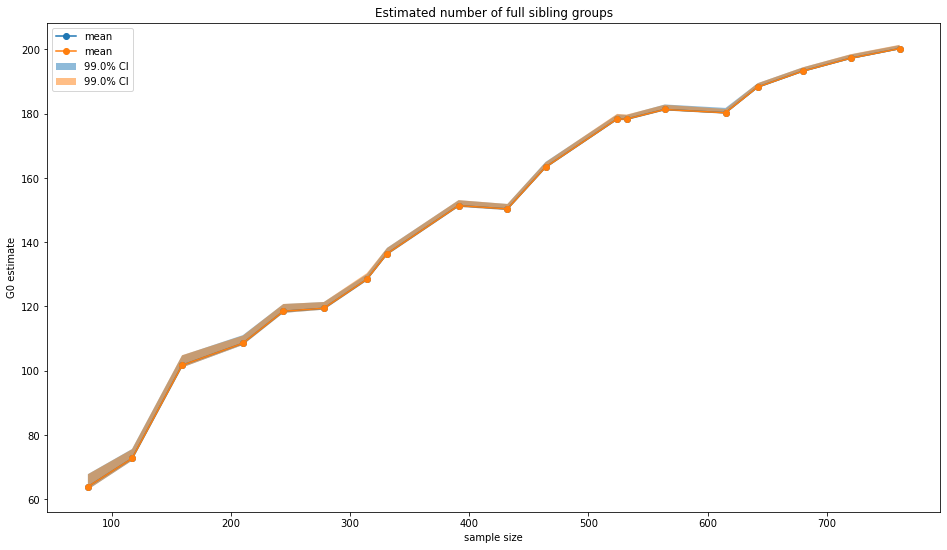

In [19]:
ax = plot_results(norm4, field='G0', title='Estimated number of full sibling groups')
ax = plot_results(beta4, field='G0', title='Estimated number of full sibling groups', ax=ax)
ax.legend()

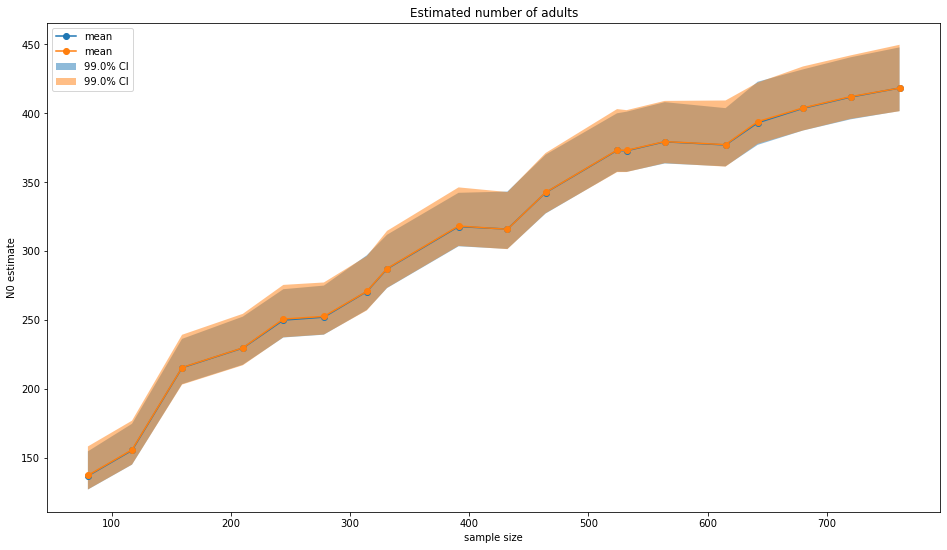

In [20]:
ax = plot_results(norm4, field='N0', title='Estimated number of adults')
ax = plot_results(beta4, field='N0', title='Estimated number of adults', ax=ax)
ax.legend()

In [22]:
norm4[-1][1].to_dataframe(['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,209.009059,200.264845,209.112370,418.121429,0.499925,0.898003,0.526759,2.674000,6.363000,0.0,4039.878515
std,1.118174,288.711081,0.0,7.132138,0.261377,7.005151,9.636552,0.002550,0.158860,0.066282,0.499786,2.343417,0.0,2.173365
min,0.000000,0.000000,0.0,200.006028,200.000057,200.012902,400.238590,0.489779,0.000040,0.432781,1.000000,1.000000,0.0,4035.938723
0.5%,0.000000,4.995000,0.0,200.058779,200.001160,200.072969,401.414168,0.493434,0.074668,0.432781,1.000000,3.000000,0.0,4036.289852
50%,1.500000,499.500000,0.0,207.320102,200.190356,207.660047,416.999567,0.499948,0.958117,0.527709,3.000000,7.000000,0.0,4039.505757
99.5%,3.000000,994.005000,0.0,233.880383,201.340510,232.574426,447.623337,0.506411,1.000000,0.618838,4.000000,15.000000,0.0,4047.651507
max,3.000000,999.000000,0.0,242.172836,202.728205,244.687333,462.776868,0.508860,1.000000,0.618838,5.000000,31.000000,0.0,4053.322018


In [ ]:
beta4[-1][1].draws_pd(['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

In [8]:
make_synth_data(150, 150, 130, 250)

,OffspringID,FatherID,MotherID
0,1,109,15
1,2,38,29
2,3,90,146
3,4,127,98
4,5,118,31
...,...,...,...
245,246,93,45
246,247,112,71
247,248,136,91
248,249,79,28


In [70]:
df5 = preprocess_data(make_synth_data(500, 500, 1000, 3100))
dfs5 = [sub_sample(df5, p=p) for p in np.linspace(0.1, 1.0, 19)]
norm5 = sample_data(dfs5, method='normal', chains=4, iter=2000)
beta5 = sample_data(dfs5, method='beta', chains=4, iter=2000)

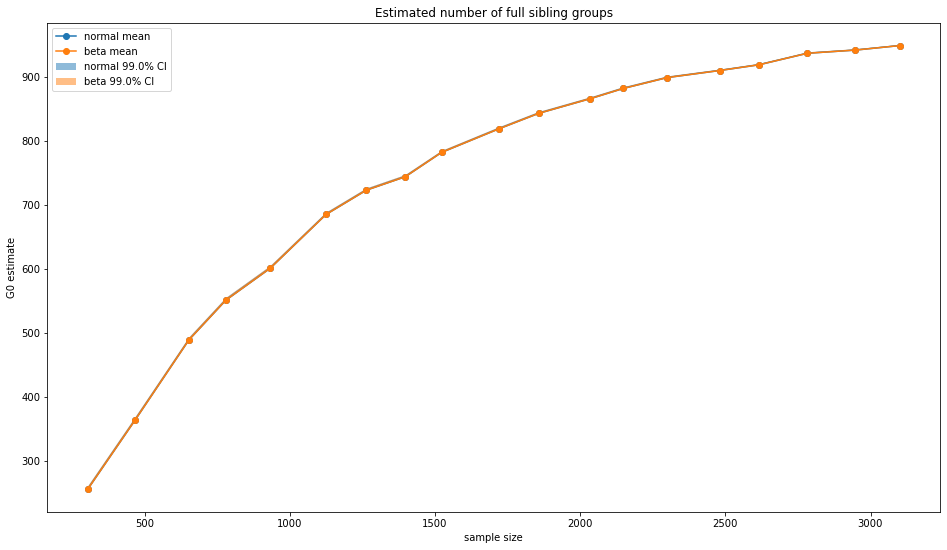

In [71]:
ax = plot_results(norm5, field='G0', title='Estimated number of full sibling groups', label='normal')
ax = plot_results(beta5, field='G0', title='Estimated number of full sibling groups', label='beta', ax=ax)
ax.legend()

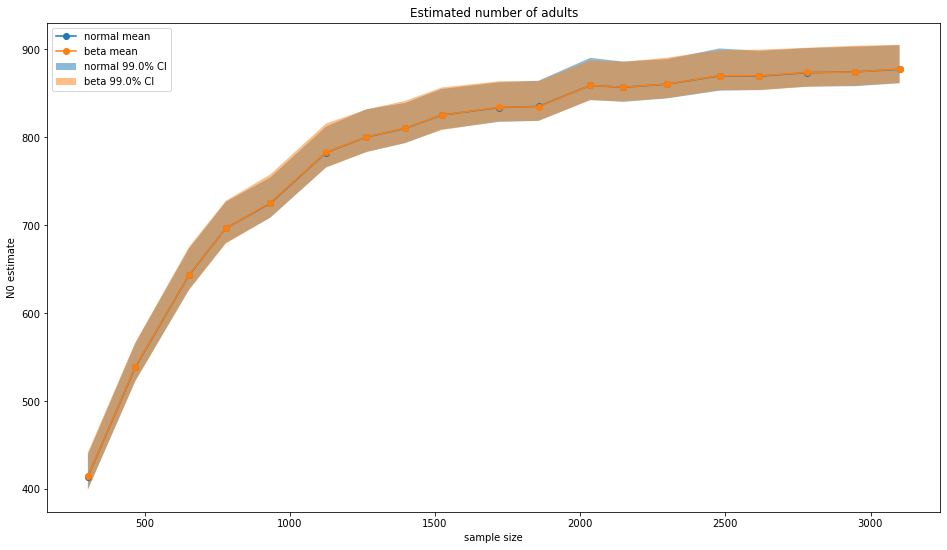

In [72]:
ax = plot_results(norm5, field='N0', title='Estimated number of adults', label='normal')
ax = plot_results(beta5, field='N0', title='Estimated number of adults', label='beta', ax=ax)
ax.legend()

In [73]:
norm5[-1][1].to_dataframe(pars=['G0', 'N0', 'M0', 'F0', 'osr']).describe(percentiles=[0.005, 0.995])

,chain,draw,warmup,F0,G0,M0,N0,osr,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
count,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.0,4000.000000
mean,1.500000,499.500000,0.0,439.579621,948.314418,437.666903,877.246524,0.500013,0.912211,0.542206,2.68525,6.352500,0.0,21257.450246
std,1.118174,288.711081,0.0,7.027922,0.307135,7.054579,9.064074,0.002464,0.137019,0.066959,0.49269,2.036856,0.0,2.168968
min,0.000000,0.000000,0.0,431.000341,948.000213,429.004197,860.090873,0.492140,0.000002,0.429611,1.00000,1.000000,0.0,21253.440322
0.5%,0.000000,4.995000,0.0,431.038795,948.001620,429.031224,861.434559,0.493853,0.141444,0.429611,1.00000,3.000000,0.0,21253.855530
50%,1.500000,499.500000,0.0,437.868631,948.217961,435.965716,876.142499,0.499989,0.959421,0.571497,3.00000,7.000000,0.0,21257.099216
99.5%,3.000000,994.005000,0.0,465.609264,949.559404,462.009731,904.717803,0.506251,1.000000,0.596219,3.00000,15.000000,0.0,21265.309619
max,3.000000,999.000000,0.0,475.127446,950.462380,486.144785,919.357031,0.508651,1.000000,0.596219,5.00000,39.000000,0.0,21268.347208
